✅ Found 102 categories: ['0', '1', '10', '100', '101', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 140MB/s]


🚀 Training new model...


Epoch 1/10: 100%|██████████| 705/705 [03:58<00:00,  2.96it/s]


Epoch 1/10 | Loss: 2.1559 | Train Acc: 46.91%


Epoch 2/10: 100%|██████████| 705/705 [03:56<00:00,  2.98it/s]


Epoch 2/10 | Loss: 1.4154 | Train Acc: 61.11%


Epoch 3/10: 100%|██████████| 705/705 [03:56<00:00,  2.98it/s]


Epoch 3/10 | Loss: 1.1927 | Train Acc: 66.58%


Epoch 4/10: 100%|██████████| 705/705 [03:56<00:00,  2.98it/s]


Epoch 4/10 | Loss: 1.0286 | Train Acc: 70.18%


Epoch 5/10: 100%|██████████| 705/705 [03:56<00:00,  2.98it/s]


Epoch 5/10 | Loss: 0.9225 | Train Acc: 72.63%


Epoch 6/10: 100%|██████████| 705/705 [03:56<00:00,  2.98it/s]


Epoch 6/10 | Loss: 0.8346 | Train Acc: 74.81%


Epoch 7/10: 100%|██████████| 705/705 [03:56<00:00,  2.98it/s]


Epoch 7/10 | Loss: 0.7632 | Train Acc: 76.82%


Epoch 8/10: 100%|██████████| 705/705 [03:56<00:00,  2.98it/s]


Epoch 8/10 | Loss: 0.7022 | Train Acc: 78.24%


Epoch 9/10: 100%|██████████| 705/705 [03:56<00:00,  2.98it/s]


Epoch 9/10 | Loss: 0.6415 | Train Acc: 80.20%


Epoch 10/10: 100%|██████████| 705/705 [03:56<00:00,  2.98it/s]


Epoch 10/10 | Loss: 0.6051 | Train Acc: 80.93%


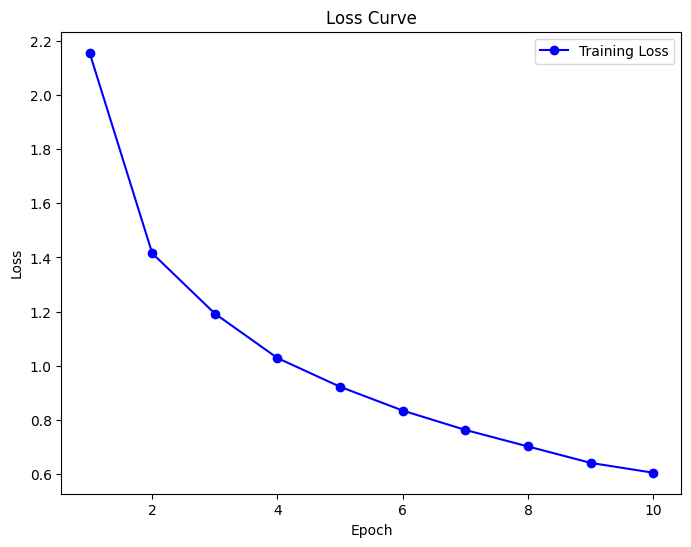

✅ Model training complete and saved!


In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import ssl

# Fix SSL Certificate Issue
ssl._create_default_https_context = ssl._create_unverified_context

# Load categories from dataset
DATASET_PATH = "/kaggle/input/ip02-dataset/classification/train"  # Adjust path if needed
categories = sorted(os.listdir(DATASET_PATH))
print(f"✅ Found {len(categories)} categories: {categories}")

# Data Augmentation & Normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom Dataset class
class PestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for label, category in enumerate(sorted(os.listdir(root_dir))):
            category_path = os.path.join(root_dir, category)
            if os.path.isdir(category_path):
                for img_name in os.listdir(category_path):
                    img_path = os.path.join(category_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Load dataset
train_dataset = PestDataset(DATASET_PATH, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

# Load EfficientNet
base_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
num_classes = len(categories)
num_features = base_model.classifier[1].in_features

# Modified EfficientNet with Dropout
class ModifiedEfficientNet(nn.Module):
    def __init__(self, base_model, num_classes):
        super(ModifiedEfficientNet, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

model = ModifiedEfficientNet(base_model, num_classes)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# Training function with early stopping
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=10, early_stop_limit=3):
    best_loss = float('inf')
    early_stop_count = 0
    loss_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        avg_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        scheduler.step(avg_loss)
        loss_history.append(avg_loss)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}%")

        if avg_loss < best_loss:
            best_loss = avg_loss
            early_stop_count = 0
        else:
            early_stop_count += 1
            if early_stop_count >= early_stop_limit:
                print("⏹ Early stopping triggered.")
                break

    # Plot training loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-', color='b', label='Training Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.show()

# Save/load model
MODEL_PATH = "./pest_classifier.pth"
if os.path.exists(MODEL_PATH):
    print("✅ Loading pre-trained model...")
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
else:
    print("🚀 Training new model...")
    train_model(model, train_loader, criterion, optimizer, scheduler, epochs=10)
    torch.save(model.state_dict(), MODEL_PATH)
    print("✅ Model training complete and saved!")


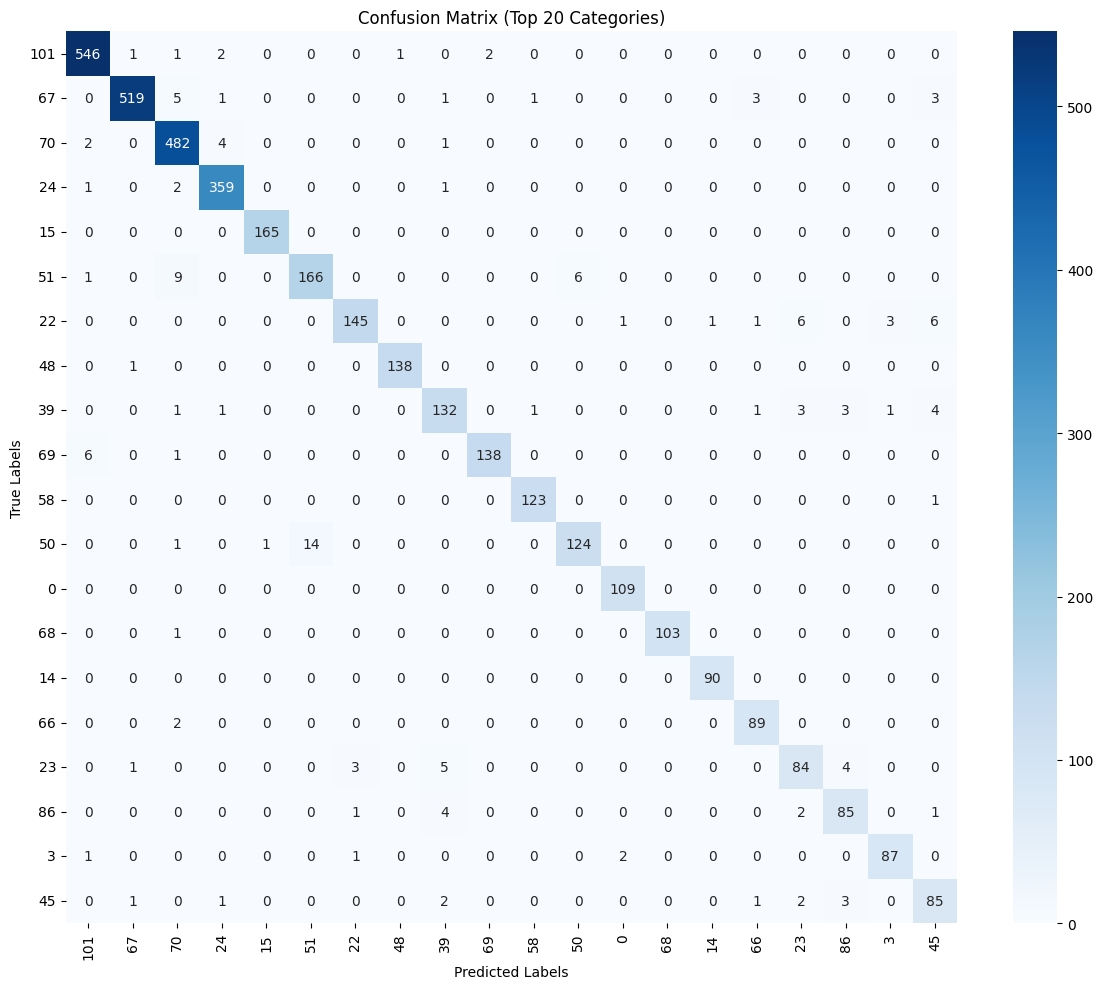

In [4]:
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

# Make sure these variables are defined from your earlier code
# - train_dataset: Your original PestDataset
# - model: Trained model
# - categories: List of class names sorted as per folder structure
# - device: CUDA or CPU
# - MODEL_PATH: Path to saved model

# 1. Split dataset into train & validation (20% for validation)
train_indices, val_indices = train_test_split(
    list(range(len(train_dataset))), test_size=0.2, random_state=42
)

# 2. Create Subsets
val_dataset = Subset(train_dataset, val_indices)
train_dataset = Subset(train_dataset, train_indices)

# 3. DataLoader for validation
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# 4. Function to find best 20 performing categories based on correct predictions
def get_best_20_categories(model, val_loader, categories):
    model.eval()
    correct_counts = Counter()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            for true, pred in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
                if true == pred:
                    correct_counts[true] += 1

    # Get top 20 categories by correct prediction count
    best_20_indices = [cat for cat, _ in correct_counts.most_common(20)]
    best_20_categories = [categories[i] for i in best_20_indices]
    return best_20_categories, best_20_indices

# 5. Function to compute and plot confusion matrix for selected categories
def compute_confusion_matrix(model, val_loader, selected_categories, selected_indices):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            labels_np = labels.cpu().numpy()
            predicted_np = predicted.cpu().numpy()

            # Keep only selected class indices
            mask = np.isin(labels_np, selected_indices)
            filtered_labels = labels_np[mask]
            filtered_preds = predicted_np[mask]

            valid_mask = np.isin(filtered_preds, selected_indices)
            final_labels = filtered_labels[valid_mask]
            final_preds = filtered_preds[valid_mask]

            all_preds.extend(final_preds)
            all_labels.extend(final_labels)

    # Map selected class indices to 0–19 for matrix display
    label_map = {orig: new for new, orig in enumerate(selected_indices)}
    all_preds = [label_map[p] for p in all_preds]
    all_labels = [label_map[l] for l in all_labels]

    assert len(all_preds) == len(all_labels), "Mismatch in predictions and labels length!"

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(selected_categories)))

    # Optionally normalize (comment out to disable)
    # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    df_cm = pd.DataFrame(cm, index=selected_categories, columns=selected_categories)

    plt.figure(figsize=(12, 10))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues", xticklabels=True, yticklabels=True)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix (Top 20 Categories)")
    plt.tight_layout()
    plt.show()

# 6. Load trained model if not already loaded
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)

# 7. Get best 20 performing categories
best_20_categories, best_20_indices = get_best_20_categories(model, val_loader, categories)

# 8. Plot confusion matrix for top 20
compute_confusion_matrix(model, val_loader, best_20_categories, best_20_indices)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129714 (\N{BEETLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129524 (\N{LOTION BOTTLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


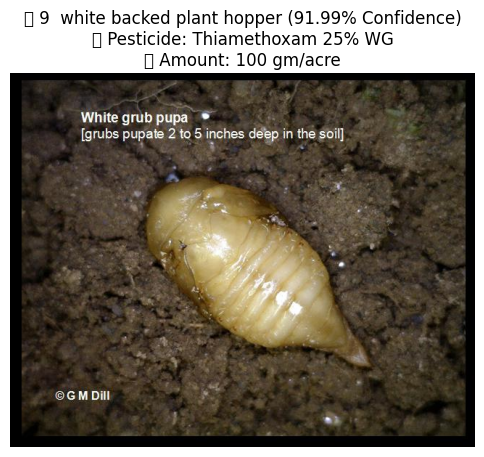

In [5]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models

# CSV: Pest class → pesticide mapping
csv_file_path = "/kaggle/input/recommendation-pest/full_pesticide_recommendation.csv"
df = pd.read_csv(csv_file_path)

# Model setup
MODEL_PATH = "./pest_classifier.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image preprocessing (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define your modified model architecture
class ModifiedEfficientNet(nn.Module):
    def __init__(self, base_model, num_classes):
        super(ModifiedEfficientNet, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(base_model.classifier[1].in_features, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Load EfficientNet base
base_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
num_classes = len(os.listdir("/kaggle/input/ip02-dataset/classification/train"))  # adjust path

# Wrap it with your modified model
model = ModifiedEfficientNet(base_model, num_classes)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# Inference + display
def classify_image(image_path):
    image = Image.open(image_path).convert("RGB")
    processed_image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(processed_image)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted_class = probabilities.max(1)
        predicted_class = predicted_class.item()
        confidence = confidence.item() * 100

    # Fetch pesticide recommendation
    pest_info = df[df["Pest Class ID"] == predicted_class]
    if not pest_info.empty:
        pest_name = pest_info["Pest Name"].values[0]
        pesticide = pest_info["Recommended Pesticide"].values[0]
        amount = pest_info["Amount"].values[0]
    else:
        pest_name, pesticide, amount = "Unknown", "N/A", "N/A"

    # Display
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(
        f"🪲 {pest_name} ({confidence:.2f}% Confidence)\n"
        f"🧴 Pesticide: {pesticide}\n"
        f"📏 Amount: {amount}"
    )
    plt.show()

# Example
image_path = "/kaggle/input/ip02-dataset/classification/test/14/08495.jpg"  # update if needed
classify_image(image_path)


In [6]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
from PIL import Image
import torchvision.transforms as transforms

# Set test data path
TEST_DATA_PATH = "/kaggle/input/ip02-dataset/classification/test"  # Adjust if needed

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transformations (same as used during training)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom Dataset class for test data
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for label, category in enumerate(sorted(os.listdir(root_dir))):
            category_path = os.path.join(root_dir, category)
            if os.path.isdir(category_path):
                for img_name in os.listdir(category_path):
                    img_path = os.path.join(category_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Load test dataset and DataLoader
test_dataset = TestDataset(TEST_DATA_PATH, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average='macro') * 100
    recall = recall_score(all_labels, all_preds, average='macro') * 100
    f1 = f1_score(all_labels, all_preds, average='macro') * 100

    # Print results
    print("\n✅ Model Performance on Test Data:")
    print(f"   Accuracy : {accuracy:.2f}%")
    print(f"   Precision: {precision:.2f}%")
    print(f"   Recall   : {recall:.2f}%")
    print(f"   F1 Score : {f1:.2f}%")

# Load trained model (make sure the architecture is defined before this)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)

# Evaluate on test data
evaluate_model(model, test_loader)



✅ Model Performance on Test Data:
   Accuracy : 67.83%
   Precision: 62.20%
   Recall   : 59.04%
   F1 Score : 59.91%


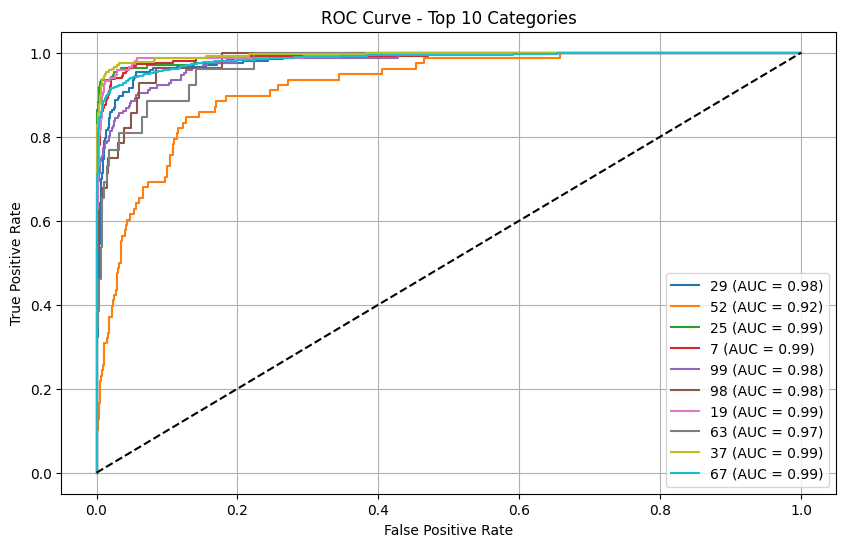

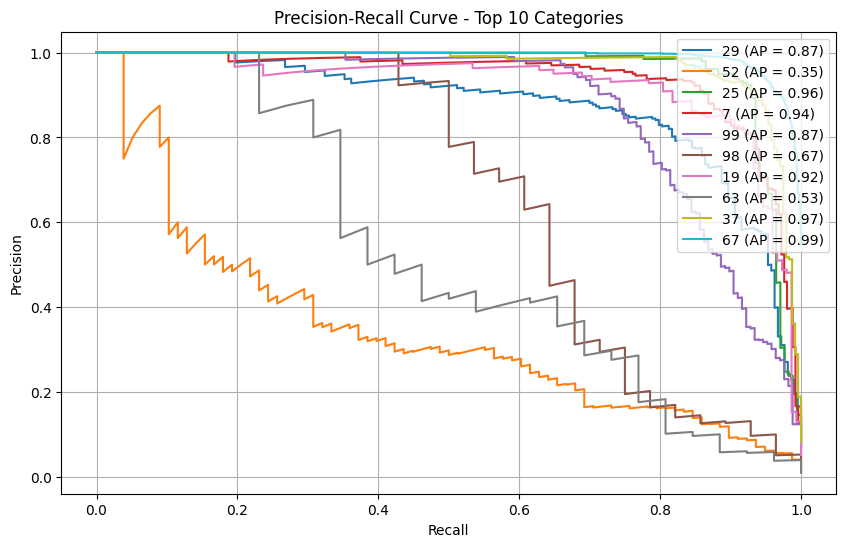

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import torchvision.transforms as transforms

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Test data path
TEST_DATA_PATH = "/kaggle/input/ip02-dataset/classification/test"

# Load category names
all_categories = sorted(os.listdir(TEST_DATA_PATH))

# Simulated match counts — replace with actual model predictions if available
category_match_counts = {i: np.random.randint(50, 200) for i in range(len(all_categories))}
best_10_indices = sorted(category_match_counts, key=category_match_counts.get, reverse=True)[:10]
best_10_categories = [all_categories[i] for i in best_10_indices]

# Transformations
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom Dataset (Filtered for top 10 categories)
class TestDataset(Dataset):
    def __init__(self, root_dir, selected_indices, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.selected_indices = set(selected_indices)

        for label, category in enumerate(sorted(os.listdir(root_dir))):
            if label in self.selected_indices:
                category_path = os.path.join(root_dir, category)
                if os.path.isdir(category_path):
                    for img_name in os.listdir(category_path):
                        img_path = os.path.join(category_path, img_name)
                        self.image_paths.append(img_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Load dataset
test_dataset = TestDataset(TEST_DATA_PATH, best_10_indices, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Load trained model (ensure model architecture is defined beforehand)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# Collect predictions and labels
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Map original labels to new labels for top 10 classes
label_map = {orig: new for new, orig in enumerate(best_10_indices)}
filtered_labels = np.array([label_map[l] for l in all_labels])
filtered_probs = np.array([[p[i] for i in best_10_indices] for p in all_probs])

# One-hot encode labels
binarized_labels = label_binarize(filtered_labels, classes=list(range(10)))

# ---------------------- ROC Curve ----------------------
plt.figure(figsize=(10, 6))
for i in range(10):
    fpr, tpr, _ = roc_curve(binarized_labels[:, i], filtered_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{best_10_categories[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Top 10 Categories")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ---------------------- Precision-Recall Curve ----------------------
plt.figure(figsize=(10, 6))
for i in range(10):
    precision, recall, _ = precision_recall_curve(binarized_labels[:, i], filtered_probs[:, i])
    avg_prec = average_precision_score(binarized_labels[:, i], filtered_probs[:, i])
    plt.plot(recall, precision, label=f"{best_10_categories[i]} (AP = {avg_prec:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Top 10 Categories")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()
